In [2]:
import os
from glob import glob
import torch
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
import numpy as np

In [3]:
data_path = "/userhome/student/bial/neural-punctuator/models/"
model_names = ["bert-base-uncased", "bert-base-cased", "albert-base-v1"]

In [4]:
files = {}
for model_name in model_names:
    f = sorted(glob(data_path + f"{model_name}-epoch*.*"), key=os.path.getmtime)
    files[model_name] = f
files

{'bert-base-uncased': ['/userhome/student/bial/neural-punctuator/models/bert-base-uncased-epoch-1.pth',
  '/userhome/student/bial/neural-punctuator/models/bert-base-uncased-epoch-2.pth',
  '/userhome/student/bial/neural-punctuator/models/bert-base-uncased-epoch-3.pth',
  '/userhome/student/bial/neural-punctuator/models/bert-base-uncased-epoch-4.pth',
  '/userhome/student/bial/neural-punctuator/models/bert-base-uncased-epoch-5.pth',
  '/userhome/student/bial/neural-punctuator/models/bert-base-uncased-epoch-6.pth',
  '/userhome/student/bial/neural-punctuator/models/bert-base-uncased-epoch-7.pth',
  '/userhome/student/bial/neural-punctuator/models/bert-base-uncased-epoch-8.pth',
  '/userhome/student/bial/neural-punctuator/models/bert-base-uncased-epoch-9.pth',
  '/userhome/student/bial/neural-punctuator/models/bert-base-uncased-epoch-10.pth',
  '/userhome/student/bial/neural-punctuator/models/bert-base-uncased-epoch-11.pth',
  '/userhome/student/bial/neural-punctuator/models/bert-base-unc

In [5]:
def load_scores(model_path):
    checkpoint = torch.load(model_path)
    return checkpoint['metrics']

def get_strict_f_score(report):
    return sum(float(report['cls_report'][output]['f1-score']) for output in ('period', 'question', 'comma')) / 3
    
# metrics = {}
# for model_name in model_names:
#     m = []
#     for file in tqdm(files[model_name]):
#         m.append(load_scores(file))
#     metrics[model_name] = m
    
# with open('metrics.pkl', 'wb') as f:
#     pickle.dump(metrics, f)
    
with open('metrics.pkl', 'rb') as f:
    metrics = pickle.load(f)
    
for _, m in metrics.items():
    for epoch in m:
        epoch['strict_f_score'] = get_strict_f_score(epoch)
        
def best_epoch_by_f_score(metrics):
    best_score = metrics[0]['strict_f_score']
    best_epoch = 0
    for i, m in enumerate(metrics):
        if m['strict_f_score'] > best_score:
            best_score = m['strict_f_score']
            best_epoch = i
    return best_epoch, best_score

def best_epoch_by_loss(metrics):
    best_loss = metrics[0]['loss']
    best_epoch = 0
    for i, m in enumerate(metrics):
        if m['loss'] < best_loss:
            best_loss = m['loss']
            best_epoch = i
    return best_epoch, best_loss

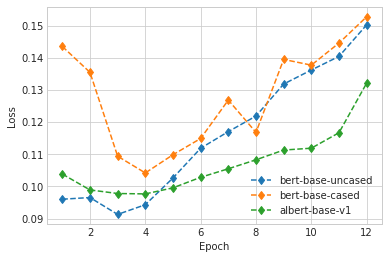

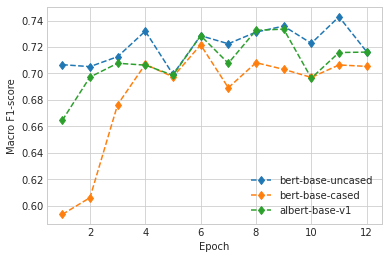

In [6]:
plt.style.use('seaborn-whitegrid')
# plt.title('Valid loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
for model_name, m in metrics.items():
    loss = [float(epoch['loss']) for epoch in m ]
    plt.plot(np.arange(len(loss))+1, loss, '--d')
plt.legend(model_names)
plt.savefig('imgs/valid_loss.pdf')
plt.show()

plt.style.use('seaborn-whitegrid')
# plt.title('Valid F1-score')
plt.ylabel('Macro F1-score')
plt.xlabel('Epoch')
for model_name, m in metrics.items():
    f_score = [float(epoch['strict_f_score']) for epoch in m ]
    plt.plot(np.arange(len(loss))+1, f_score, '--d')
plt.legend(model_names)
plt.savefig('imgs/valid_f1_score.pdf')
plt.show()

In [7]:
from neural_punctuator.utils.data import get_config_from_yaml
from neural_punctuator.models.BertPunctuator import BertPunctuator

import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
from neural_punctuator.data.dataloader import BertDataset, collate, get_data_loaders, get_datasets
from neural_punctuator.models.BertPunctuator import BertPunctuator
from torch.optim import AdamW
from torch import nn

from neural_punctuator.utils.io import save, load
from neural_punctuator.utils.metrics import get_total_grad_norm, get_eval_metrics
import numpy as np
import pickle

from torch.utils.data import Dataset, DataLoader
from itertools import product

In [15]:
def combine(pred_num, all_valid_preds):

    relevant_preds = all_valid_preds[::pred_num]

    ps = []

    for i in range(relevant_preds.shape[0]):#+512//pred_num-1):
    #     ps.append(relevant_preds[i, :pred_num])


        start_idx = max(0, i-512//pred_num+1)
        end_idx = min(relevant_preds.shape[0], i+1)

        p = []
        for j, k in enumerate(range(start_idx, end_idx)):
            j = end_idx - start_idx - j - 1
    #         print(k, j, relevant_preds[k][j*pred_num:(j+1)*pred_num].mean())
            p.append(relevant_preds[k][j*pred_num:(j+1)*pred_num])
    #     print()
        p = np.stack(p)
        
#         if p.shape[0] > 2:
#             p = p[1:-1, :, :]
            
        ps.append(np.log(np.exp(p).mean(0)))

    ps = np.concatenate(ps)
    
    return ps

def evaluate_multiple_predictions(model_name, model_type):
    print(model_name, model_type)
    
    if model_type == 'by_f_score':
        epoch, _ = best_epoch_by_f_score(metrics[model_name])
    elif model_type == 'by_loss':
        epoch, _ = best_epoch_by_loss(metrics[model_name])
    else:
        raise ValueError("Model type not valid, options: by_f_score/by_loss")
        
    config = get_config_from_yaml(f'neural_punctuator/configs/config-{model_name}-unfreeze.yaml')
    config.trainer.load_model = f"{model_name}-epoch-{epoch+1}.pth"
    
    config.model.predict_step = 1 
    config.predict.batch_size = 128
    
    model = BertPunctuator(config)
    model.to(device)

    load(model, None, config)
    
    valid_dataset = BertDataset("valid", config)
    
    valid_loader = DataLoader(valid_dataset, batch_size=config.predict.batch_size, collate_fn=collate)
    
    model.eval()
    all_valid_preds = []
    
    with open(f"all_valid_preds_{model_name}_{model_type}.pkl", "wb") as f:
        pickle.dump(all_valid_preds, f)

    for data in tqdm(valid_loader):
        text, targets = data
        with torch.no_grad():
            preds, _ = model(text.to(device))

        all_valid_preds.append(preds.detach().cpu().numpy())
        
    all_valid_target = valid_dataset.targets
    all_valid_preds = np.concatenate(all_valid_preds)
    pred_num = config.model.seq_len // config.model.predict_step
    
    all_targets = []
    all_preds = []

    for i in tqdm(range(0, all_valid_preds.shape[0]//pred_num)):
        targets = all_valid_target[i*config.model.seq_len: (i+1)*config.model.seq_len]

        preds = all_valid_preds[i*pred_num]

        all_targets.append(targets)
        all_preds.append(preds)
        
    targets = np.concatenate(all_targets)
    preds = np.concatenate(all_preds)
    
    preds = preds[targets != -1]
    targets = targets[targets != -1]
    
    # config.trainer.show_confusion_matrix = True
    f_scores = []
    reports = []
    pred_num = 1
    while pred_num <= 128:
        ps = combine(pred_num, all_valid_preds)
        _targets = np.array(all_valid_target[:ps.shape[0]])

        ps = ps[_targets != -1]
        _targets = _targets[_targets != -1]

        report = get_eval_metrics(_targets, ps, config)
        reports.append(report)
        strict_f_score = get_strict_f_score(report)
    #     print(pred_num, strict_f_score)
        f_scores.append(strict_f_score)
        pred_num *= 2

    with open(f'reports/report_{model_name}_{model_type}.pkl', 'wb') as f:
        pickle.dump(reports, f)


    plt.style.use('seaborn-whitegrid')
    # plt.title('Multiple predictions')
    plt.ylabel('Macro F1-score')
    plt.xlabel('Number of predictions per token')
    plt.xticks(np.arange(int(np.log2(512))+1), [str(2**i) for i in range(0, int(np.log2(512))+1)])
    plt.plot(f_scores[::-1], '--d')
    plt.savefig(f'imgs/valid_multiple_predictions/{model_name}_{model_type}.pdf')
    plt.show()

In [16]:
class BertDataset(Dataset):
    def __init__(self, prefix, config, is_train=False):

        self.config = config
        self.is_train = is_train

        with open(self.config.data.data_path + prefix + "_data.pkl", 'rb') as f:
            texts, targets = pickle.load(f)
            self.encoded_texts = [word for t in texts for word in t]
            self.targets = [t for ts in targets for t in ts]

    def __getitem__(self, idx):
        if self.is_train:
            shift = np.random.randint(self.config.trainer.seq_shift) - self.config.trainer.seq_shift // 2
        else:
            shift = 0

        start_idx = idx * self.config.model.predict_step + shift
        start_idx = max(0, start_idx)
        end_idx = start_idx + self.config.model.seq_len
        return torch.LongTensor(self.encoded_texts[start_idx: end_idx]),\
               torch.LongTensor(self.targets[start_idx: end_idx])

    def __len__(self):
        return (len(self.encoded_texts)-self.config.model.seq_len)//self.config.model.predict_step + 1

In [17]:
model_name_type_configs = [(model_name, model_type) for model_name, model_type in product(model_names, ('by_loss', 'by_f_score'))]
model_name_type_configs

[('bert-base-uncased', 'by_loss'),
 ('bert-base-uncased', 'by_f_score'),
 ('bert-base-cased', 'by_loss'),
 ('bert-base-cased', 'by_f_score'),
 ('albert-base-v1', 'by_loss'),
 ('albert-base-v1', 'by_f_score')]

In [18]:
device = torch.device('cuda:0')
torch.cuda.set_device(device)

for model_name, model_type in model_name_type_configs:
     evaluate_multiple_predictions(model_name, model_type)

bert-base-uncased by_loss


  1%|▏         | 2/147 [00:10<13:12,  5.47s/it]


KeyboardInterrupt: 